In [1]:
env = 'pc'  # 'colab' or 'pc'
using_gpu = False  # True or False

saving_metrics_report = True
saving_train_times = True
saving_histories = True

n_trial = 1

git_download_path = 'https://raw.githubusercontent.com/PashaIanko/Covid19Classifier/main/'

# Number of trial for this day (-> directory/24-01-22/trial-{n_trial}/ -- example of directories)

# Packages & functions

In [2]:
# %%capture
def download_files(url_dict):
    for file, url in url_dict.items():
        print(f'Downloading {file}')
        !wget -O {file} {url} {file}


if env == 'colab':
    from google.colab import drive
    drive.mount('/content/drive')

    
    files = [
            'DataProperties.py',
            'DatasetParameters.py',
            'Preprocessing.py',
            'PreprocessingParameters.py',
            
            'Model.py',
            'BNModel.py',
            'CNNModel.py',
            'VGG19Model.py',
            'VGG16Model.py',
            'AlexNetModel.py',
            'DropoutModel.py',
            'InceptionModel.py',
            'ResNetModel.py',

            'Utils.py',
            'ModelUtils.py',
            'TimeCallBack.py'
    ]

In [3]:
%%capture
if env == 'colab':
    url_dict = {file: git_download_path + file for file in files[:3]}
    download_files(url_dict)

In [4]:
%%capture
if env == 'colab':
    url_dict = {file: git_download_path + file for file in files[3:6]}
    download_files(url_dict)

In [5]:
%%capture
if env == 'colab':
    url_dict = {file: git_download_path + file for file in files[6:]}
    download_files(url_dict)

In [6]:
import os
import numpy as np
# import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
# from os import listdir

C:\Users\79137\anaconda3\envs\tf\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\79137\anaconda3\envs\tf\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\79137\anaconda3\envs\tf\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\79137\anaconda3\envs\tf\lib\site-packages\tensorflow\python\framework\dty

In [7]:
# Models
# from tensorflow.keras import models
# from tensorflow.keras.layers import Conv2D as Conv2D
# from tensorflow.keras.layers import BatchNormalization as BatchNormalization
# from tensorflow.keras.layers import ReLU as ReLU
# from tensorflow.keras.layers import MaxPool2D as MaxPool2D
# from tensorflow.keras.layers import Flatten as Flatten
# from tensorflow.keras.layers import Dense as Dense
# from tensorflow.keras.layers import Input as Input

from os.path import isdir
import os
import numpy as np

# Plotting
import seaborn as sns

# Utils
import importlib
from os.path import isdir
from datetime import date
import pandas as pd

# Dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [8]:
import DataProperties 
import PreprocessingParameters 
import Preprocessing
import DatasetParameters
import Utils
import CNNModel
import BNModel
import ResNetModel
import DropoutModel
import InceptionModel
import AlexNetModel
import VGG19Model
import VGG16Model
import Model
import ModelUtils
import TimeCallBack

def reload_all(modules_list):
    for module in modules_list:
        importlib.reload(module)

reload_all(
    [
        DataProperties,
        PreprocessingParameters,
        DatasetParameters,
        Utils,
        Preprocessing,

        Model,
        CNNModel,
        BNModel,
        DropoutModel,
        
        VGG16Model,
        ResNetModel,
        InceptionModel,
        ModelUtils,
        TimeCallBack,
        VGG19Model,
        AlexNetModel
    ]
)

from DataProperties import DataProperties
from PreprocessingParameters import PreprocessingParameters
from DatasetParameters import DatasetParameters
from Utils import *
from Preprocessing import *
from CNNModel import CNNModel
from BNModel import BNModel
from DropoutModel import DropoutModel
from VGG19Model import VGG19Model
from ResNetModel import ResNetModel
from InceptionModel import InceptionModel
from ModelUtils import ModelUtils
from TimeCallBack import TimeCallBack
from AlexNetModel import AlexNetModel
from VGG16Model import VGG16Model

In [9]:
DataProps = DataProperties(
    environment = env,
    n_trial = n_trial
)

# Class balance

## Paths download

In [10]:
assert isdir(DataProps.test_data_path) == True
assert isdir(DataProps.models_path) == True

In [11]:
train_files = calc_files(directory = DataProps.train_data_path)
train_covid_files = calc_files(DataProps.train_covid_path)
train_pn_files = calc_files(DataProps.train_pneumonia_path)
train_healthy_files = calc_files(DataProps.train_healthy_path)

assert train_files == (train_covid_files + train_pn_files + train_healthy_files)

In [12]:
val_files = calc_files(directory = DataProps.val_data_path)
val_covid_files = calc_files(DataProps.val_covid_path)
val_pn_files = calc_files(DataProps.val_pneumonia_path)
val_healthy_files = calc_files(DataProps.val_healthy_path)

assert val_files == (val_covid_files + val_pn_files + val_healthy_files)

In [13]:
test_files = calc_files(DataProps.test_data_path)
test_covid_files = calc_files(DataProps.test_covid_path)
test_pn_files = calc_files(DataProps.test_pneumonia_path)
test_healthy_files = calc_files(DataProps.test_healthy_path)

assert test_files == (test_covid_files + test_pn_files + test_healthy_files)

Text(0, 0.5, 'y')

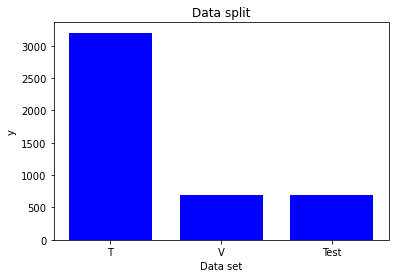

In [14]:
x = ['T', 'V', 'Test']
y = [train_files, val_files, test_files]

fig, ax = plt.subplots()    
width = 0.75 # the width of the bars 
ax.bar(x, y, width, color="blue")
plt.title('Data split')
plt.xlabel('Data set')
plt.ylabel('y') 

# Creating test dataset

## Train

In [15]:
# train_generator = ImageDataGenerator(
#     # we use only a portion for train data (initially, to check if all works fine)
#     validation_split = 1 - train_percentage,  

#     # preprocessing
#     preprocessing_function = Preprocessing.preprocess,
#     samplewise_center = DatasetParameters.samplewise_center,
#     featurewise_center = DatasetParameters.featurewise_center,
    
#     # augmentation
#     width_shift_range = DatasetParameters.width_shift_range,
#     height_shift_range = DatasetParameters.height_shift_range,
#     rotation_range = DatasetParameters.rotation_range,
#     horizontal_flip = DatasetParameters.horizontal_flip,
#     vertical_flip = DatasetParameters.vertical_flip,
#     # brightness_range = [0.8, 1.0],
#     zoom_range = DatasetParameters.zoom_range
# )

# train_flow = train_generator.flow_from_directory(
#     directory = DataProps.train_data_path,
#     target_size = PreprocessingParameters.target_shape,
#     color_mode = 'rgb',
#     classes = DataProperties.classes,
#     class_mode = 'sparse',  # 1D integer labels
#     batch_size = DatasetParameters.batch_size,
#     subset = 'training',
#     shuffle = DatasetParameters.shuffle_train,
#     seed = DatasetParameters.seed
# )
# print(f'Use {train_flow.n} images for train')

## Validation

In [16]:
# val_generator = ImageDataGenerator(
#     preprocessing_function = Preprocessing.preprocess,
#     validation_split = 1 - val_percentage
# )

# val_flow = train_generator.flow_from_directory(
#     directory = DataProps.val_data_path,
#     target_size = PreprocessingParameters.target_shape,
#     color_mode = 'rgb',
#     classes = DataProperties.classes,
#     class_mode = 'sparse',  # 1D integer labels
#     batch_size = DatasetParameters.batch_size,
#     subset = 'training',  # yes, training - we use val_split of data 
#     shuffle = DatasetParameters.shuffle_validation,
#     seed = DatasetParameters.seed
# )

# print(f'Use {val_flow.n} images for validation')

## Test

In [17]:
test_generator = ImageDataGenerator(
    preprocessing_function = Preprocessing.preprocess,
    validation_split = 0.001
)

test_flow = test_generator.flow_from_directory(
    directory = DataProps.test_data_path,
    target_size = PreprocessingParameters.target_shape,
    color_mode = 'rgb',
    classes = DataProperties.classes,
    class_mode = 'sparse',
    shuffle = DatasetParameters.shuffle_test,
    seed = DatasetParameters.seed,
    batch_size = 1,
    subset = 'training'
)

print(f'Use {test_flow.n} images for test')

Found 687 images belonging to 3 classes.
Use 687 images for test


# Visualizing dataset

In [18]:
# how_many_to_show = 9
# flow = test_flow
# for _ in range(9):
#     batch, labels = flow.next()
#     print(batch.shape, np.max(batch))
#     assert np.max(batch) <= 1.01
#     assert np.min(batch) >= 0.0
    
#     visualize(
#         batch, 
#         labels, 
#         how_many_to_show, 
#         class_indices = flow.class_indices,
#         figsize=(15, 15)
#     )

# Fitting models

## Prepare steps

In [19]:
# train_steps = train_flow.n // train_flow.batch_size
# validation_steps = val_flow.n // val_flow.batch_size
test_steps = test_flow.n // test_flow.batch_size

# what_to_monitor = 'val_loss'
# validation_data = val_flow
# validation_steps = validation_steps

# early_stop = tf.keras.callbacks.EarlyStopping(
#     monitor = what_to_monitor,
#     patience = 2,  # 3
#     mode = 'auto',
#     restore_best_weights = True
# )

# print(f'Train steps: {train_flow.n, train_steps}')
# print(f'Val steps: {val_flow.n, validation_steps}')
print(f'Test steps: {test_flow.n, test_steps}')

Test steps: (687, 687)


## Get_models()

In [20]:
def get_empty_models():
    res = {
        'CNN': CNNModel(name = 'CNN'),
        'VGG19': VGG19Model(name = 'VGG19'),
        'VGG16': VGG16Model(name = 'VGG16'),
        'BN': BNModel(name = 'BN_CNN'),
        'Dropout': DropoutModel(name = 'Dropout'),
        'AlexNet': AlexNetModel(name = 'AlexNet')
    }
    return res
    
def construct_utils(model_name):
    return ModelUtils(

        model_params_dict = dict(**model_params),

        checkpoint_params_dict = dict(
            filepath = f'{DataProps.checkpoint_path}{model_name}/',
            **checkpoint_params
        ),

        train_params_dict = dict(
            **train_params
        )
    )

def get_models(model_names):
    empty_models = get_empty_models()
    empty_model_names = list(empty_models.keys())
    res = {}

    for name in model_names:
        assert name in empty_model_names
        model = empty_models[name]
        utils = construct_utils(name)

        res.update(
            {
                name: {
                    'model': model,
                    'utils': utils
                }
            }
        )
    return res

In [21]:
train_params = dict(
    train_flow = None, # train_flow,
    train_steps = None, # train_steps,

    val_flow = None, #validation_data,
    val_steps = None, #validation_steps,

    epochs = DatasetParameters.epochs
)


model_params = dict(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['acc'] 
)

checkpoint_params = dict(
    save_freq = 'epoch',
    save_weights_only = True,
    save_best_only = False,
    verbose = 1
)

In [22]:
  # ['CNN', 'VGG16']
# models = get_models(names)
# histories = {
#     # Fills after training
# }

In [23]:
if using_gpu:
    device_name = tf.test.gpu_device_name()
    if device_name != '/device:GPU:0':
        print(
            '\n\nThis error most likely means that this notebook is not '
            'configured to use a GPU.  Change this in Notebook Settings via the '
            'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
        raise SystemError('GPU device not found')

## Summaries

In [24]:
# for name in names:
#     print(f'\nPrinting summary of {name}')
#     print_summary(models, name)

## Fit

In [25]:
# def fit_models(models_dict):
#     for model_name, parameters in models_dict.items():
#         print(f'\nFitting {model_name}')
#         model = parameters['model']
#         utils = parameters['utils']
        
#         model.construct_model()
#         model.compile_model(**utils.model_params_dict)

#         checkpoint = tf.keras.callbacks.ModelCheckpoint(**utils.checkpoint_params_dict)

#         callbacks = [
#             early_stop,
#             checkpoint,
#             model.epoch_time_callback
#         ]

#         if using_gpu:
#             print(f'Fitting with GPU')
#             with tf.device(device_name):
#                 history = fit_(
#                     **utils.train_params_dict,
#                     model = model.model,
#                     callbacks = callbacks
#                 )
#         else:
#             print(f'Fitting without GPU')
#             history = fit_(
#                 **utils.train_params_dict,
#                 model = model.model,
#                 callbacks = callbacks
#             )
#         histories[model_name] = history  

#         if saving_models:
#             save_dir = f'{DataProps.models_path}{model.name}/'
            
#             if not(isdir(save_dir)):
#                 os.mkdir(save_dir)
#             assert os.path.isdir(save_dir) == True
            
#             print(f'saving model to dir: {save_dir}')
#             model.save_model(
#                 dir = save_dir
#             )

#     if saving_histories:
#         print(f'Saving histories to {DataProps.histories_path}')
#         save_histories(histories, DataProps.histories_path)
#     return histories

In [26]:
# histories = fit_models(
#     models_dict = models
# )

In [27]:
# To check if bugs

# m = collect_metrics(
#     {'CNN': models['CNN']['model']}, test_flow, test_steps
# )

# Models evaluation

## Full training time

In [28]:
# if saving_train_times:
#     save_train_times(
#         models_dict = models,
#         save_dir = DataProps.models_path + 'training_time.csv'
#     )

In [29]:
# visualize_full_train_time(
#     models_dict = models
# )

## Seconds per epoch

In [30]:
# visualize_epoch_time(
#     models_dict = models
# )

## Models reload

In [31]:
# print(models)
# del models

In [32]:
def reload_models(names, directory):
    res_dict = {}
    models = get_models(names)
    for name, model_parameters in models.items():
    
        model = model_parameters['model']
        utils = model_parameters['utils']
        
        model.construct_model()
        model.compile_model(**utils.model_params_dict)
        load_dir = f'{directory}{model.name}/{model.name}.h5'
        # save_dir = f'{DataProps.models_path}{model.name}/{model.name}.h5'
    
        model.model.load_weights(load_dir)
        res_dict[name] = model
    
    return res_dict

names = ['CNN', 'Dropout']
models = reload_models(names, directory = f'{DataProps.models_path}')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [33]:
DataProps.models_path

'C:/Users/79137/Pasha/2. UNIPD/HDA/Project/SavedModels//2022-01-29/trial-1/'

In [34]:
models

{'CNN': <CNNModel.CNNModel at 0x2a277b98f08>,
 'Dropout': <DropoutModel.DropoutModel at 0x2a277b98908>}

## Test flow performance

In [35]:
if using_gpu:
    print(f'Fitting with GPU')
    with tf.device(device_name):
        metrics_dict = collect_metrics(models, test_flow, test_steps)
else:
    metrics_dict = collect_metrics(models, test_flow, test_steps)

  4/687 [..............................] - ETA: 23s - loss: 1.0174 - acc: 1.0000

C:\Users\79137\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


687/687 [==============================] - 13s 19ms/step - loss: 1.0651 - acc: 0.4774


In [36]:
def normalize_col(df, colnames):
    for c in colnames:
        df[c + '_norm'] = df[c] / np.max(df[c])

test_metrics_df = pd.DataFrame(metrics_dict).transpose()

normalize_col(
    test_metrics_df,
    [
        'data_eval_time_sec',
        'tr_params',
        'test_loss^(-1)'
    ]
)

In [38]:
test_metrics_df.head()

,data_eval_time_sec,data_size,test_loss^(-1),test_accuracy,F1,precision,recall,tr_params,data_eval_time_sec_norm,tr_params_norm,test_loss^(-1)_norm
CNN,20.041571,687.0,12.90479,0.416303,0.310337,0.448943,0.416303,10788643.0,1.000000,0.898974,1.000000
Dropout,13.200726,687.0,1.06509,0.477438,0.470192,0.489581,0.477438,12001059.0,0.658667,1.000000,0.082534


In [39]:
if saving_metrics_report:
    print(f'Saving metrics to {DataProps.models_path}')
    test_metrics_df.to_csv(DataProps.models_path + 'test_metrics_res.csv')

Saving metrics to C:/Users/79137/Pasha/2. UNIPD/HDA/Project/SavedModels//2022-01-29/trial-1/


<Figure size 1080x1080 with 0 Axes>

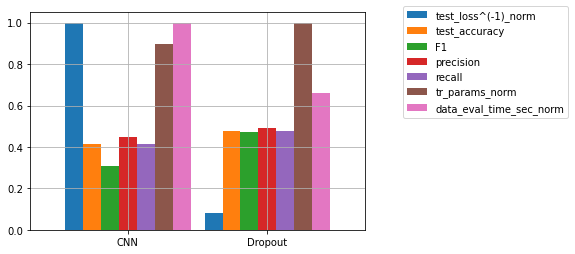

In [40]:
metrics_to_show = [
                   'test_loss^(-1)_norm',
                   'test_accuracy',
                   'F1',
                   'precision',
                   'recall',
                   
                   'tr_params_norm',
                   'data_eval_time_sec_norm'
]

plt.figure(figsize = (15, 15))
ax = test_metrics_df.loc[:, metrics_to_show].plot.bar(
    rot = 0,
    width = 0.9
)
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.grid()

## Confusion matrices

In [41]:
models

{'CNN': <CNNModel.CNNModel at 0x2a277b98f08>,
 'Dropout': <DropoutModel.DropoutModel at 0x2a277b98908>}

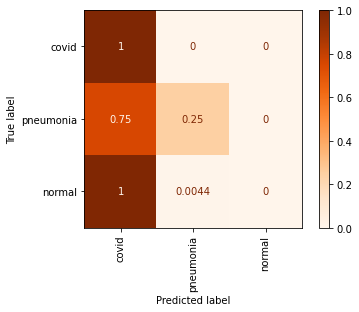

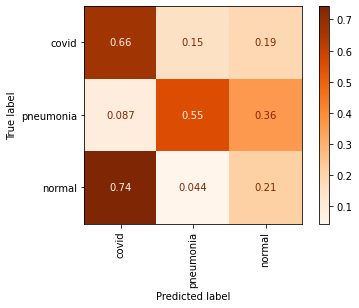

In [42]:
for m_name, model in models.items():
    test_flow.reset()
    plot_confusion_matrix(
        Y_true = test_flow.classes, 
        Y_pred = model.flow_predict(
            test_flow,
            test_steps
        ),
        class_indices = test_flow.class_indices
    )

## Learning curves

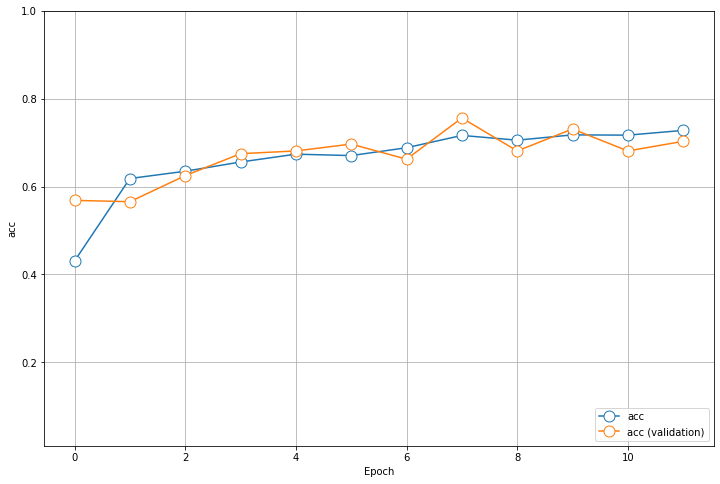

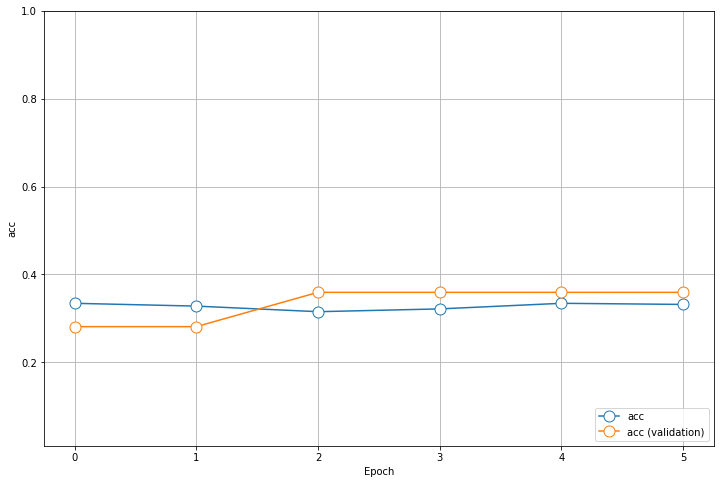

In [48]:
for m_name, history in histories.items():
    plot_history(
        history = history.history,
        metrics_name = 'acc',
        plot_validation = True
    )

## Layers interpretation

We have:
        3 by 3 kernel, 
        of 3 color channels,
        total: 16 kernels


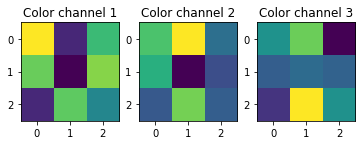

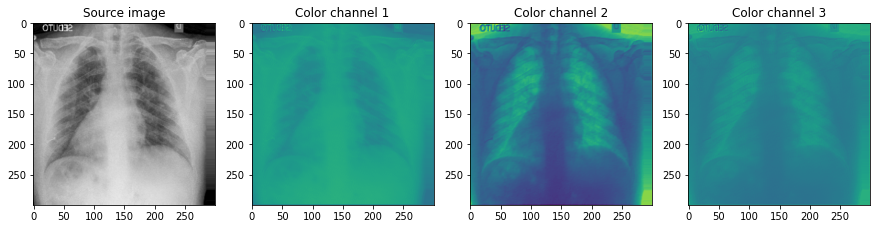

In [49]:
visualize_kernel_work(
    model = models['CNN'].model, 
    n_layer = 0, 
    n_kernel = 0, 
    image = train_flow[0][0][10],  # 10th image
    label = train_flow[0][1][10],  # 10th image 
    n_color_channels = PreprocessingParameters.n_color_channels[0]
)

We have:
        3 by 3 kernel, 
        of 16 color channels,
        total: 32 kernels


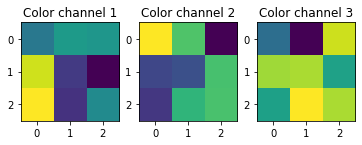

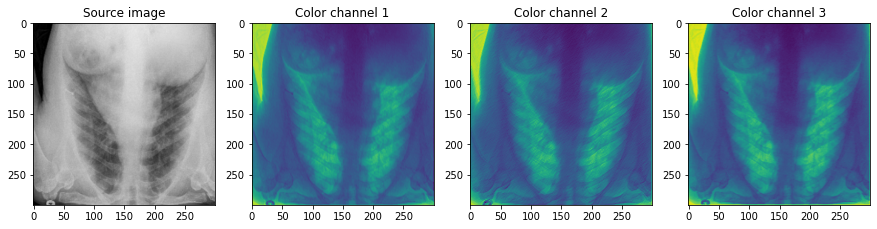

In [50]:
visualize_kernel_work(
    model = models['CNN'].model, 
    n_layer = 2,
    n_kernel = 0, 
    image = train_flow[0][0][10],  # 10th image
    label = train_flow[0][1][10],  # 10th image 
    n_color_channels = PreprocessingParameters.n_color_channels[0]
)

We have:
        3 by 3 kernel, 
        of 64 color channels,
        total: 256 kernels


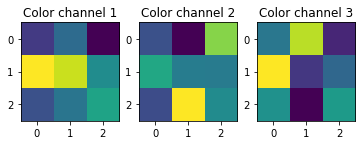

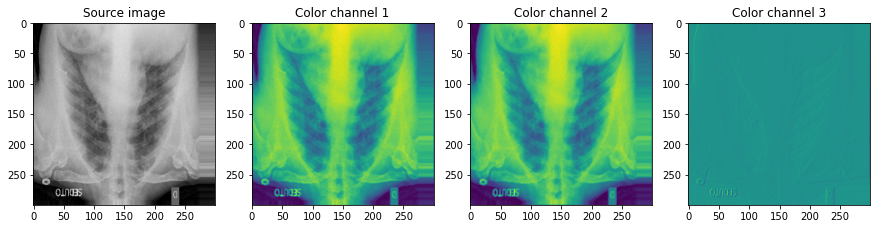

In [51]:
visualize_kernel_work(
    model = models['CNN'].model,
    n_layer = 6,
    n_kernel = 0, 
    image = train_flow[0][0][10],  # 10th image
    label = train_flow[0][1][10],  # 10th image 
    n_color_channels = PreprocessingParameters.n_color_channels[0]
)